In [35]:
PROJECT_ID = 'york-bb-cohort'
BQ_LOCATION = 'US'
REGION = 'us-west2'
GCS_BUCKET = f"{PROJECT_ID}-asmi"

BQ_DATASET = f"{PROJECT_ID}:asmi_bq"

In [8]:

CREATE OR REPLACE VIEW asmi_bq.wholedata AS (
  WITH first_values AS (
    SELECT
      DISTINCT CONCAT(fullVisitorId, visitId,number) AS unique_id,
      IFNULL(visitNumber, 0) AS visitNumber,
      IFNULL(channelGrouping, '') AS channelGrouping,
      IFNULL(device_category, '') AS device_category,
      IFNULL(operating_system, '') AS operating_system,
      IFNULL(traffic_source, '') AS traffic_source,
      IFNULL(traffic_medium, '') AS traffic_medium,
      IFNULL(traffic_campaign, '') AS traffic_campaign,
      IFNULL(country, '') AS country,
      IFNULL(city, '') AS city,
      IFNULL(bounces, 0) AS bounces,
      IFNULL(hits, 0) AS hits,
      IFNULL(newVisits, 0) AS newVisits,
      IFNULL(time_on_site, 0) AS time_on_site,
      IFNULL(visits, 0) AS visits,
      IFNULL(pageviews_per_session, 0) AS pageviews_per_session,
      IFNULL(number, 0) AS number,
      IFNULL(hitTime, 0) AS hitTime,
      IFNULL(hour, 0) AS hour,
      IFNULL(minute, 0) AS minute,
      addToCart,
      CASE
        WHEN ABS(MOD(FARM_FINGERPRINT(CONCAT(fullVisitorId, visitId,number)), 10)) <= 7 THEN 'TRAIN'
        WHEN ABS(MOD(FARM_FINGERPRINT(CONCAT(fullVisitorId, visitId, number)), 10)) = 8 THEN 'EVAL'
        WHEN ABS(MOD(FARM_FINGERPRINT(CONCAT(fullVisitorId, visitId, number)), 10)) = 9 THEN 'TEST'
        ELSE '' 
      END AS data_split
    FROM
      `york-bb-cohort.asmi_bq.data1`
     
  )
  SELECT
    unique_id,
    visitNumber,
    channelGrouping,
    device_category,
    operating_system,
    traffic_source,
    traffic_medium,
    traffic_campaign,
    country,
    city,
    bounces,
    hits,
    newVisits,
    time_on_site,
    visits,
    pageviews_per_session,
    number,
    hitTime,
    hour,
    minute,
    addToCart,
    -- Feature Engineering
    EXTRACT(DAYOFWEEK FROM TIMESTAMP_SECONDS(hitTime)) AS hitDayOfWeek,
    EXTRACT(HOUR FROM TIMESTAMP_SECONDS(hitTime)) AS hitHourOfDay,
    IFNULL(pageviews_per_session / visits, 0) AS avgPageviewsPerVisit,
    IFNULL(hits / visits, 0) AS avgHitsPerVisit,
    data_split
  FROM
    first_values
);




Query is running:   0%|          |

""


In [11]:
%%bigquery

CREATE OR REPLACE MODEL asmi_bq.treeclass2

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  INPUT_LABEL_COLS=["addToCart"],
  DATA_SPLIT_METHOD="CUSTOM",
  DATA_SPLIT_COL="data_split",
  ENABLE_GLOBAL_EXPLAIN=True,
  
  num_trials=8,
  max_parallel_trials=4,
  HPARAM_TUNING_OBJECTIVES=["roc_auc"],
  EARLY_STOP=True,
  # Hyperpameter search space.
  LEARN_RATE=HPARAM_RANGE(0.01, 0.1),
  MAX_TREE_DEPTH=HPARAM_CANDIDATES([5,6]),
  AUTO_CLASS_WEIGHTS = True
) AS

SELECT
  * EXCEPT(unique_id)
FROM
  asmi_bq.wholedata

Query is running:   0%|          |

""


In [12]:
%%bigquery
SELECT *
FROM
  ML.TRIAL_INFO(MODEL `asmi_bq.treeclass2`);

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'learn_rate': 0.1, 'max_tree_depth': 6}",{'roc_auc': 0.8355934065934066},0.503046,0.504574,SUCCEEDED,None,False
1,2,"{'learn_rate': 0.08022029348571431, 'max_tree_...",{'roc_auc': 0.8244015984015984},0.531499,0.529189,SUCCEEDED,None,False
2,3,"{'learn_rate': 0.07306123539888118, 'max_tree_...",{'roc_auc': 0.8328631368631368},0.520894,0.521810,SUCCEEDED,None,False
3,4,"{'learn_rate': 0.04967134761440729, 'max_tree_...",{'roc_auc': 0.8186483516483517},0.572017,0.569903,SUCCEEDED,None,False
4,5,"{'learn_rate': 0.1, 'max_tree_depth': 5}",{'roc_auc': 0.8268071928071928},0.516281,0.514042,SUCCEEDED,None,False
5,6,"{'learn_rate': 0.0875831931854634, 'max_tree_d...",{'roc_auc': 0.8322357642357643},0.512501,0.514308,SUCCEEDED,None,False
6,7,"{'learn_rate': 0.09614004090060467, 'max_tree_...",{'roc_auc': 0.8359300699300699},0.505327,0.507574,SUCCEEDED,None,True
7,8,"{'learn_rate': 0.08761994944511492, 'max_tree_...",{'roc_auc': 0.8235954045954046},0.530990,0.528626,SUCCEEDED,None,False


In [13]:
MODEL_NAME="treeclass2"

In [ ]:
## Evaluate BQML XGBoost model performance

In [14]:
%%bigquery
SELECT
  *
FROM
  ML.EVALUATE(MODEL asmi_bq.treeclass2)
WHERE trial_id=1;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.053573,0.908206,0.607205,0.101178,0.53383,0.8227


In [99]:
%%bigquery --project $PROJECT_ID

SELECT
  expected_label,
  _0 AS predicted_0,
  _1 AS predicted_1
FROM
  ML.CONFUSION_MATRIX(MODEL bqmlga4.churn_xgb)
WHERE trial_id=1;

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,predicted_0,predicted_1
0,0,39308,0
1,1,1905,0


In [17]:
%%bigquery df_roc 

SELECT * FROM ML.ROC_CURVE(MODEL asmi_bq.treeclass2)

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: title={'center': 'AUC-ROC curve'}, xlabel='false_positive_rate'>

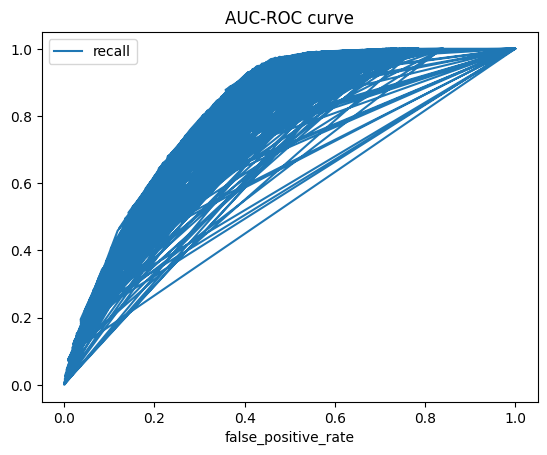

In [18]:
df_roc.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")

In [20]:
%%bigquery 

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL asmi_bq.treeclass2)
ORDER BY
  attribution DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,feature,attribution
0,7,number,0.342567
1,7,hits,0.261544
2,7,pageviews_per_session,0.094991
3,7,hitTime,0.035449
4,7,visitNumber,0.035066
5,7,time_on_site,0.021526
6,7,hitHourOfDay,0.009064
7,7,country,0.008174
8,7,channelGrouping,0.006143
9,7,minute,0.005472


In [ ]:
#Generate batch predictions

In [21]:
%%bigquery 

SELECT
  *
FROM
  ML.PREDICT(MODEL asmi_bq.treeclass2,
  (SELECT * FROM asmi_bq.wholedata   WHERE data_split = "TEST"))

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,predicted_addToCart,predicted_addToCart_probs,unique_id,visitNumber,channelGrouping,device_category,operating_system,traffic_source,traffic_medium,...,number,hitTime,hour,minute,addToCart,hitDayOfWeek,hitHourOfDay,avgPageviewsPerVisit,avgHitsPerVisit,data_split
0,7,1,"[{'label': 1, 'prob': 0.5639470815658569}, {'l...",2570254437881194970148563105013,1,Organic Search,desktop,Macintosh,(direct),(none),...,13,100547,11,19,0,6,3,10.0,14.0,TEST
1,7,0,"[{'label': 1, 'prob': 0.22843262553215027}, {'...",734752278490108401114856291803,1,Direct,desktop,Windows,(direct),(none),...,3,192834,10,49,0,7,5,14.0,14.0,TEST
2,7,0,"[{'label': 1, 'prob': 0.36688387393951416}, {'...",7499601002670852411148566474811,1,Referral,desktop,Macintosh,(direct),(none),...,11,231439,20,43,0,7,16,14.0,14.0,TEST
3,7,0,"[{'label': 1, 'prob': 0.25721871852874756}, {'...",411011133624650219514856182242,3,Organic Search,desktop,Windows,(direct),(none),...,2,369049,7,49,0,2,6,10.0,14.0,TEST
4,7,1,"[{'label': 1, 'prob': 0.5321716666221619}, {'l...",411011133624650219514856182246,3,Organic Search,desktop,Windows,(direct),(none),...,6,1711295,8,12,0,3,19,10.0,14.0,TEST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29532,7,1,"[{'label': 1, 'prob': 0.6482557058334351}, {'l...",496621724472103308514853840848,3,Referral,desktop,Macintosh,(direct),(none),...,8,86204,14,42,0,5,23,12.0,19.0,TEST
29533,7,0,"[{'label': 1, 'prob': 0.19023127853870392}, {'...",915505766361040911414853715122,1,Social,desktop,Macintosh,reddit.com,referral,...,2,45818,11,12,0,5,12,17.0,19.0,TEST
29534,7,1,"[{'label': 1, 'prob': 0.5870636105537415}, {'l...",2974605056109531395148540202113,1,Social,desktop,Windows,youtube.com,referral,...,13,488665,19,48,0,3,15,12.0,19.0,TEST
29535,7,0,"[{'label': 1, 'prob': 0.27288222312927246}, {'...",985062273739623871714853670413,1,Direct,mobile,Android,(direct),(none),...,3,65172,9,58,0,5,18,16.0,19.0,TEST


In [24]:
%%bigquery 

CREATE OR REPLACE TABLE asmi_bq.test_prediction1 AS (
SELECT
    unique_id,
    addToCart,
    predicted_addToCart,
    predicted_addToCart_probs AS predicted_addToCart_prob
FROM
  ML.PREDICT(MODEL asmi_bq.treeclass2,
  (SELECT * FROM asmi_bq.wholedata))
);

Query is running:   0%|          |

""


In [25]:
%%bigquery prediction_result
select * from asmi_bq.test_prediction1

Query is running:   0%|          |

Downloading:   0%|          |

In [26]:
print('Actual', prediction_result['addToCart'].value_counts())
print('Predicted',prediction_result['predicted_addToCart'].value_counts())

Actual addToCart
0    292732
1      7342
Name: count, dtype: Int64
Predicted predicted_addToCart
0    174089
1    125985
Name: count, dtype: Int64


In [27]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score

actual = prediction_result['addToCart']
predicted = prediction_result['predicted_addToCart']

# Calculate recall
recall = recall_score(actual, predicted)

# Calculate precision
precision = precision_score(actual, predicted)

# Calculate accuracy
accuracy = accuracy_score(actual, predicted)

# Calculate F1 score
f1 = f1_score(actual, predicted)

# Calculate ROC AUC score
roc_auc = roc_auc_score(actual, predicted)

# Print the metrics
print('Recall:', recall)
print('Precision:', precision)
print('Accuracy:', accuracy)
print('F1 Score:', f1)
print('ROC AUC Score:', roc_auc)

Recall: 0.9489239989103786
Precision: 0.055300234154859705
Accuracy: 0.6021214767024134
F1 Score: 0.10450996422330061
ROC AUC Score: 0.7711736674655196


In [ ]:
### Export BQML model to GCS

In [28]:
BQ_MODEL = f"{BQ_DATASET}.{MODEL_NAME}"
BQ_MODEL_EXPORT_DIR = f"gs://{GCS_BUCKET}/{MODEL_NAME}"

In [29]:
!bq --location=$BQ_LOCATION extract \
--destination_format ML_XGBOOST_BOOSTER \
--model $BQ_MODEL \
$BQ_MODEL_EXPORT_DIR

Waiting on bqjob_r57a47ca4b0cc5950_0000018dc3b7915f_1 ... (5s) Current status: DONE   


In [30]:
IMAGE_URI='us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.1-4:latest'

In [49]:
from google.cloud import bigquery
from google.cloud import aiplatform as vertexai
import pandas as pd

In [32]:
model = vertexai.Model.upload(
    display_name=MODEL_NAME,
    artifact_uri=BQ_MODEL_EXPORT_DIR,
    serving_container_image_uri=IMAGE_URI,
)

Creating Model
Create Model backing LRO: projects/319407066227/locations/us-central1/models/3665576053935439872/operations/5430215285061713920
Model created. Resource name: projects/319407066227/locations/us-central1/models/3665576053935439872@1
To use this Model in another session:
model = aiplatform.Model('projects/319407066227/locations/us-central1/models/3665576053935439872@1')


In [33]:
endpoint = model.deploy(
    traffic_split={"0": 100},
    machine_type="e2-standard-2",
)

Creating Endpoint
Create Endpoint backing LRO: projects/319407066227/locations/us-central1/endpoints/8500361777731600384/operations/819655166541168640
Endpoint created. Resource name: projects/319407066227/locations/us-central1/endpoints/8500361777731600384
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/319407066227/locations/us-central1/endpoints/8500361777731600384')
Deploying model to Endpoint : projects/319407066227/locations/us-central1/endpoints/8500361777731600384
Deploy Endpoint model backing LRO: projects/319407066227/locations/us-central1/endpoints/8500361777731600384/operations/2938598791218987008
Endpoint model deployed. Resource name: projects/319407066227/locations/us-central1/endpoints/8500361777731600384


In [85]:
%%bigquery data_df --project $PROJECT_ID

SELECT * 
FROM asmi_bq.wholedata

Query is running:   0%|          |

Downloading:   0%|          |

In [86]:
data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300074 entries, 0 to 300073
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   unique_id              300074 non-null  object 
 1   visitNumber            300074 non-null  Int64  
 2   channelGrouping        300074 non-null  object 
 3   device_category        300074 non-null  object 
 4   operating_system       300074 non-null  object 
 5   traffic_source         300074 non-null  object 
 6   traffic_medium         300074 non-null  object 
 7   traffic_campaign       300074 non-null  object 
 8   country                300074 non-null  object 
 9   city                   300074 non-null  object 
 10  bounces                300074 non-null  Int64  
 11  hits                   300074 non-null  Int64  
 12  newVisits              300074 non-null  Int64  
 13  time_on_site           300074 non-null  Int64  
 14  visits                 300074 non-nu

In [87]:
categorical_features=data_df.select_dtypes(include=['object'])
exclude_columns = ['unique_id', 'data_split']
categorical_features = categorical_features.drop(columns=exclude_columns, errors='ignore')

In [88]:
categorical_features

,channelGrouping,device_category,operating_system,traffic_source,traffic_medium,traffic_campaign,country,city
0,Referral,desktop,Linux,(direct),(none),(not set),Israel,not available in demo dataset
1,Organic Search,desktop,Windows,google,organic,(not set),New Zealand,not available in demo dataset
2,Affiliates,desktop,Windows,Partners,affiliate,Data Share Promo,Germany,not available in demo dataset
3,Affiliates,desktop,Windows,Partners,affiliate,Data Share Promo,Germany,not available in demo dataset
4,Social,desktop,Macintosh,reddit.com,referral,(not set),United States,not available in demo dataset
...,...,...,...,...,...,...,...,...
300069,Direct,desktop,Android,(direct),(none),(not set),Belgium,not available in demo dataset
300070,Organic Search,desktop,Windows,(direct),(none),(not set),United States,not available in demo dataset
300071,Direct,desktop,Macintosh,(direct),(none),(not set),United Kingdom,London
300072,Direct,mobile,iOS,(direct),(none),(not set),France,not available in demo dataset


In [89]:
from sklearn.preprocessing import OrdinalEncoder

In [90]:
def _build_cat_feature_encoders(cat_feature_list, gcs_bucket, model_name, na_value='Unknown'):

    
    feature_encoders = {}
    
    for idx, feature in enumerate(cat_feature_list):
        feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        feature_vocab_file = f"gs://{gcs_bucket}/{model_name}/assets/{idx}_categorical_label.txt"
        feature_vocab_df = pd.read_csv(feature_vocab_file, delimiter = "\t", header=None).fillna(na_value)
        feature_encoder.fit(feature_vocab_df.values)
        feature_encoders[feature] = feature_encoder
    
    return feature_encoders

In [91]:
def preprocess_xgboost(instances, cat_feature_list, feature_encoders):
  
    transformed_instances = []
    
    for instance in instances:
        for feature in cat_feature_list:
            feature_int = feature_encoders[feature].transform([[instance[feature]]]).item()
            instance[feature] = feature_int
            instance_list = list(instance.values())
        transformed_instances.append(instance_list)

    return transformed_instances

In [69]:
feature_encoders = _build_cat_feature_encoders(categorical_features, GCS_BUCKET, MODEL_NAME)

In [92]:
%%bigquery test_df --project $PROJECT_ID 

SELECT* EXCEPT (unique_id, addToCart, data_split)
FROM asmi_bq.wholedata
WHERE data_split="TEST"
LIMIT 3;

Query is running:   0%|          |

Downloading:   0%|          |

In [93]:
test_instances = test_df.astype(str).to_dict(orient='records')

In [94]:
# Apply preprocessing to transform categorical features and return numerical instances for prediction.
transformed_test_instances = preprocess_xgboost(test_instances, categorical_features, feature_encoders)

In [95]:
# Generate predictions from model deployed to Vertex AI Endpoint.
predictions = endpoint.predict(instances=transformed_test_instances)

In [98]:
for idx, prediction in enumerate(predictions.predictions):
    # Class labels [1,0] retrieved from model_metadata.json in GCS model dir.
    # BQML binary classification default is 0.5 with above "is_added" and below "Not added".
    is_added = "addToCart" if prediction[0] >= 0.5 else "Not addToCart"
    print(f"Prediction: Customer {idx} - {is_added} {prediction}")
    print(test_df.iloc[idx].astype(str).to_json() + "\n")

Prediction: Customer 0 - addToCart [0.5677937269210815, 0.4322063028812408]
{"visitNumber":"1","channelGrouping":"Paid Search","device_category":"desktop","operating_system":"Windows","traffic_source":"(direct)","traffic_medium":"(none)","traffic_campaign":"(not set)","country":"United States","city":"not available in demo dataset","bounces":"0","hits":"16","newVisits":"1","time_on_site":"609","visits":"1","pageviews_per_session":"11","number":"6","hitTime":"56627","hour":"19","minute":"53","hitDayOfWeek":"5","hitHourOfDay":"15","avgPageviewsPerVisit":"11.0","avgHitsPerVisit":"16.0"}

Prediction: Customer 1 - addToCart [0.5677937269210815, 0.4322063028812408]
{"visitNumber":"1","channelGrouping":"Paid Search","device_category":"desktop","operating_system":"Windows","traffic_source":"(direct)","traffic_medium":"(none)","traffic_campaign":"(not set)","country":"United States","city":"not available in demo dataset","bounces":"0","hits":"16","newVisits":"1","time_on_site":"609","visits":"1